In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
import argparse
import copy
from tqdm import tqdm
import torch

import warnings, os

def short_formatwarning(msg, category, filename, lineno, line=None):
    return f"{os.path.basename(filename)}:{lineno}: {category.__name__}: {msg}\n"

warnings.formatwarning = short_formatwarning
warnings.filterwarnings("always", category=RuntimeWarning)

from cosmoglint.utils.training_utils import MyDataset
from cosmoglint.model.transformer import transformer_model

from matplotlib.colors import LogNorm

gpu_id = 1
device = torch.device("cuda:{:d}".format(gpu_id) if torch.cuda.is_available() else "cpu")

def plot_running_mean(x, value, window_size, show_diff=False, **kwargs):
    cumsum = np.cumsum(np.insert(value, 0, 0))
    y = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    x = x[window_size-1:]

    if len(y) == 0:
        print("Warning: No data to plot.")
        return None, None
    
    if show_diff:
        y -= y.min()
        plt.plot(x, y, **kwargs)
    else:
        plt.plot(x, y, **kwargs)
    
    return x, y

def my_savefig(fout):
    plt.tight_layout()
    plt.savefig(fout, bbox_inches="tight")
    print(f"Saved figure to {fout}")

_param_names = [r"${\rm SFR}$", r"${d}$", r"${v}_r$", r"${v}_\theta$"]
param_names = [r"$\rm SFR \ [M_\odot /yr]$", r"$d\ [{\rm Mpc}/h]$", r"$v_r \ \rm [km/s]$", r"$v_\theta \ \rm [km/s]$"]

param_labels = ["sfr", "d", "vr", "vt"]

base_dir = "../scripts/runs/output_transformer"
#base_dir = "../scripts/runs/output_transformer_with_TNG-Cluster"

# Load Model and Plot Loss

Final mean validation loss: 2.218
opt:  Namespace(gpu_id='0', output_dir='./runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02', seed=12345, max_length=50, use_dist=True, use_vel=True, norm_param_file='./norm_params_33.txt', data_path=['../dataset/TNG300-1/TNG300-1_33.h5'], train_ratio=0.9, batch_size=512, num_epochs=40, lr=0.0001, dropout=0.0, sampler_weight_min=0.02, lambda_penalty_loss=0, save_freq=10, model_name='transformer1', d_model=128, num_layers=4, num_heads=8, num_features_out=100, num_features_in=4, norm_params=[[11.0, 15.0], [-3.2, 2.9], [-3.0, 1.0], [-4.0, 4.0], [-2.0, 4.0]])
Transformer1(
  (embedding_layers): Sequential(
    (0): Linear(in_features=4, out_features=127, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=127, out_features=127, bias=True)
  )
  (context_embedding_layers): Sequential(
    (0): Linear(in_features=1, out_features=127, bias=True)
    (1): LeakyReLU(negative_slope=0.

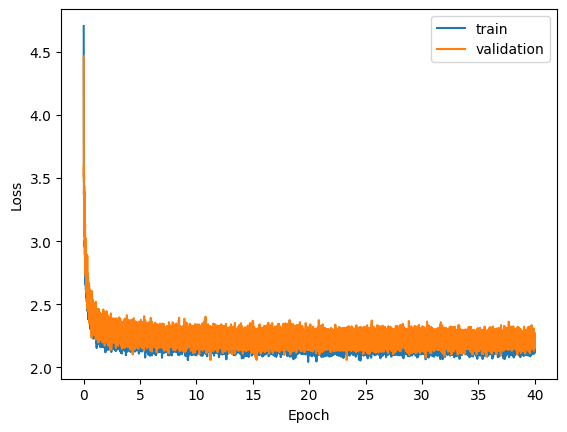

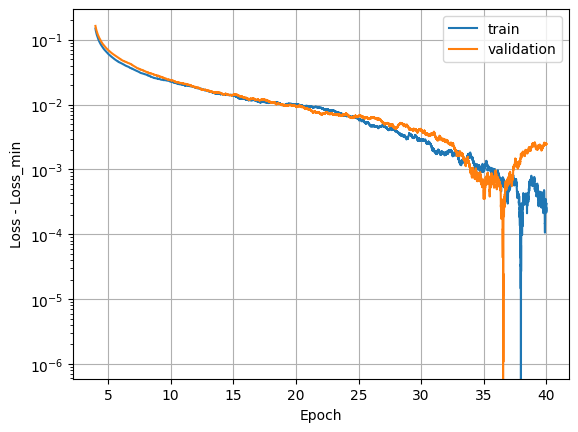

In [3]:
snapshot_number = 33
model_dir = "{}/transformer1_{:d}_use_vel_ep40_bs512_w0.02".format(base_dir, snapshot_number)
max_ids = np.loadtxt("../scripts/param_files/max_ids_20_{:d}.txt".format(snapshot_number), dtype=int)
max_ids = torch.tensor(max_ids, dtype=torch.long).to(device)

output_dir = "{}/figures".format(model_dir)
os.makedirs(output_dir, exist_ok=True)

### plot loss 
loss = np.loadtxt("{}/log.txt".format(model_dir), comments="#")
plt.figure()
x = loss[:,0]
plt.plot(x, loss[:,1], label="train")
#plot_running_mean(x, loss[:,2], 100, label="validation")
plt.plot(x, loss[:,2], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure()
dx = min(int(len(x)/10), 10000)
plot_running_mean(x, loss[:,1], dx, show_diff=True, label="train")
plot_running_mean(x, loss[:,2], dx, show_diff=True, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss - Loss_min")
plt.yscale("log")
plt.grid()
plt.legend()

print("Final mean validation loss: {:.3f}".format(loss[-100:,2].mean()))


### load parameters
with open("{}/args.json".format(model_dir), "r") as f:
    opt = json.load(f, object_hook=lambda d: argparse.Namespace(**d))
print("opt: ", opt)

norm_params = np.array(opt.norm_params)
xmin, xmax = norm_params[:, 0], norm_params[:,1]

### load model
model = transformer_model(opt)
model.to(device)

model.load_state_dict(torch.load("{}/model.pth".format(model_dir)))
#model.load_state_dict(torch.load(f"{model_dir}/model_ep10.pth"))

model.eval()
print(model)

# Plot Probability Distribution

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/prob_sfr_0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/prob_sfr_1.pdf


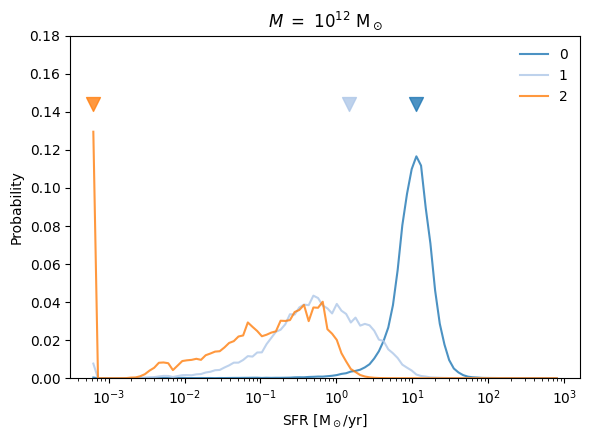

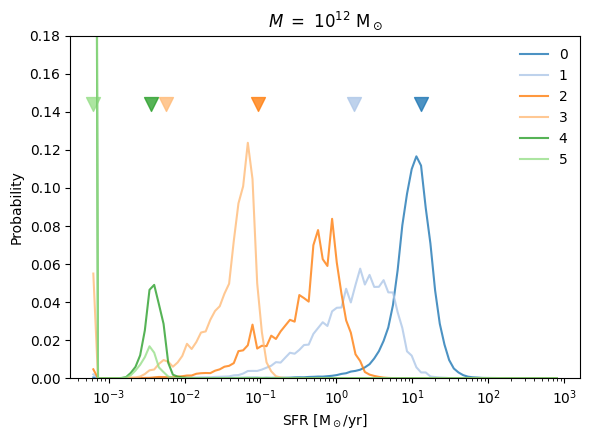

In [3]:
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(20)] * 10

def show_prob(prob, generated, length, iparam=0, title=None, ylim=(0, 0.18), log_scale=False):
    plt.figure(figsize=(6, 4.5))
    plt.title(title)
        
    val_phys = np.linspace(0, 1, opt.num_features_out) * (xmax[iparam+1] - xmin[iparam+1]) + xmin[iparam+1]
    gen_phys = generated[:,iparam] * (xmax[iparam+1] - xmin[iparam+1]) + xmin[iparam+1]

    if iparam != 2:
        val_phys = 10 ** val_phys
        gen_phys = 10 ** gen_phys
        plt.xscale("log")
    
    for k in range(length+1):
        label = f"{k}"
        if k == 0 and ( iparam == 1 or iparam == 2 ):
            continue
        if k != 0 and iparam != 0:
            prob[k,iparam,0] = 0.0
        prob[k,iparam,:] /= prob[k,iparam,:].sum()
        plt.plot(val_phys, prob[k,iparam], label=label, color=colors[k], alpha=0.8)
        plt.scatter(gen_phys[k], ylim[1]*0.8, marker="v", color=colors[k], s=100, alpha=0.8)

    if log_scale:
        plt.yscale("log")
    else:
        plt.ylim(*ylim)
    plt.xlabel(f"{param_names[iparam]}")
    plt.ylabel("Probability")
    plt.legend(frameon=False)
    
    my_savefig("{}/prob_{}_{:d}.pdf".format(output_dir, param_labels[iparam], i))

## Quick check of the output and probability
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

threshold = ( -3.0 - xmin[1] ) / ( xmax[1] - xmin[1])
def calc_length(x, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        for j in range(skip_length, seq_length):
            if x[i,j,ref_param] < threshold:
                break
        length[i] = j
    return length

x_test_physical_unit = 12.00
x_test = ( x_test_physical_unit - xmin[0] ) / ( xmax[0] - xmin[0] )
x_test = [ x_test ] * 100
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
generated_test, prob = model.generate(x_test, prob_threshold=1e-5, max_ids=max_ids)
generated_test = generated_test.detach().cpu().numpy()
prob = prob.detach().cpu().numpy()

length_generated_test = calc_length(generated_test)

for i, (x, g) in enumerate(zip(x_test, generated_test)):
    for iparam in [0]: #range(opt.num_features_in):
        """
        print(f"{x.item():.4f}: ", end="")
        for j, gg in enumerate(g[:,iparam]):
            print(f"{gg:.4f} ", end="")
            if j == length_generated_test[i]:
                break

        print("| ")
        """

        if i < 2:
            if iparam == 0:
                title = r"$M\  =\ 10^{%.0f}\ \rm M_\odot$" % (x_test_physical_unit)
            else:
                title = None
            
            show_prob(prob[i], g, length_generated_test[i], iparam=iparam, title=title) #, log_scale=True)
            

# Show Spatial Distribution of Galaxies around Halo

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/distribution.pdf


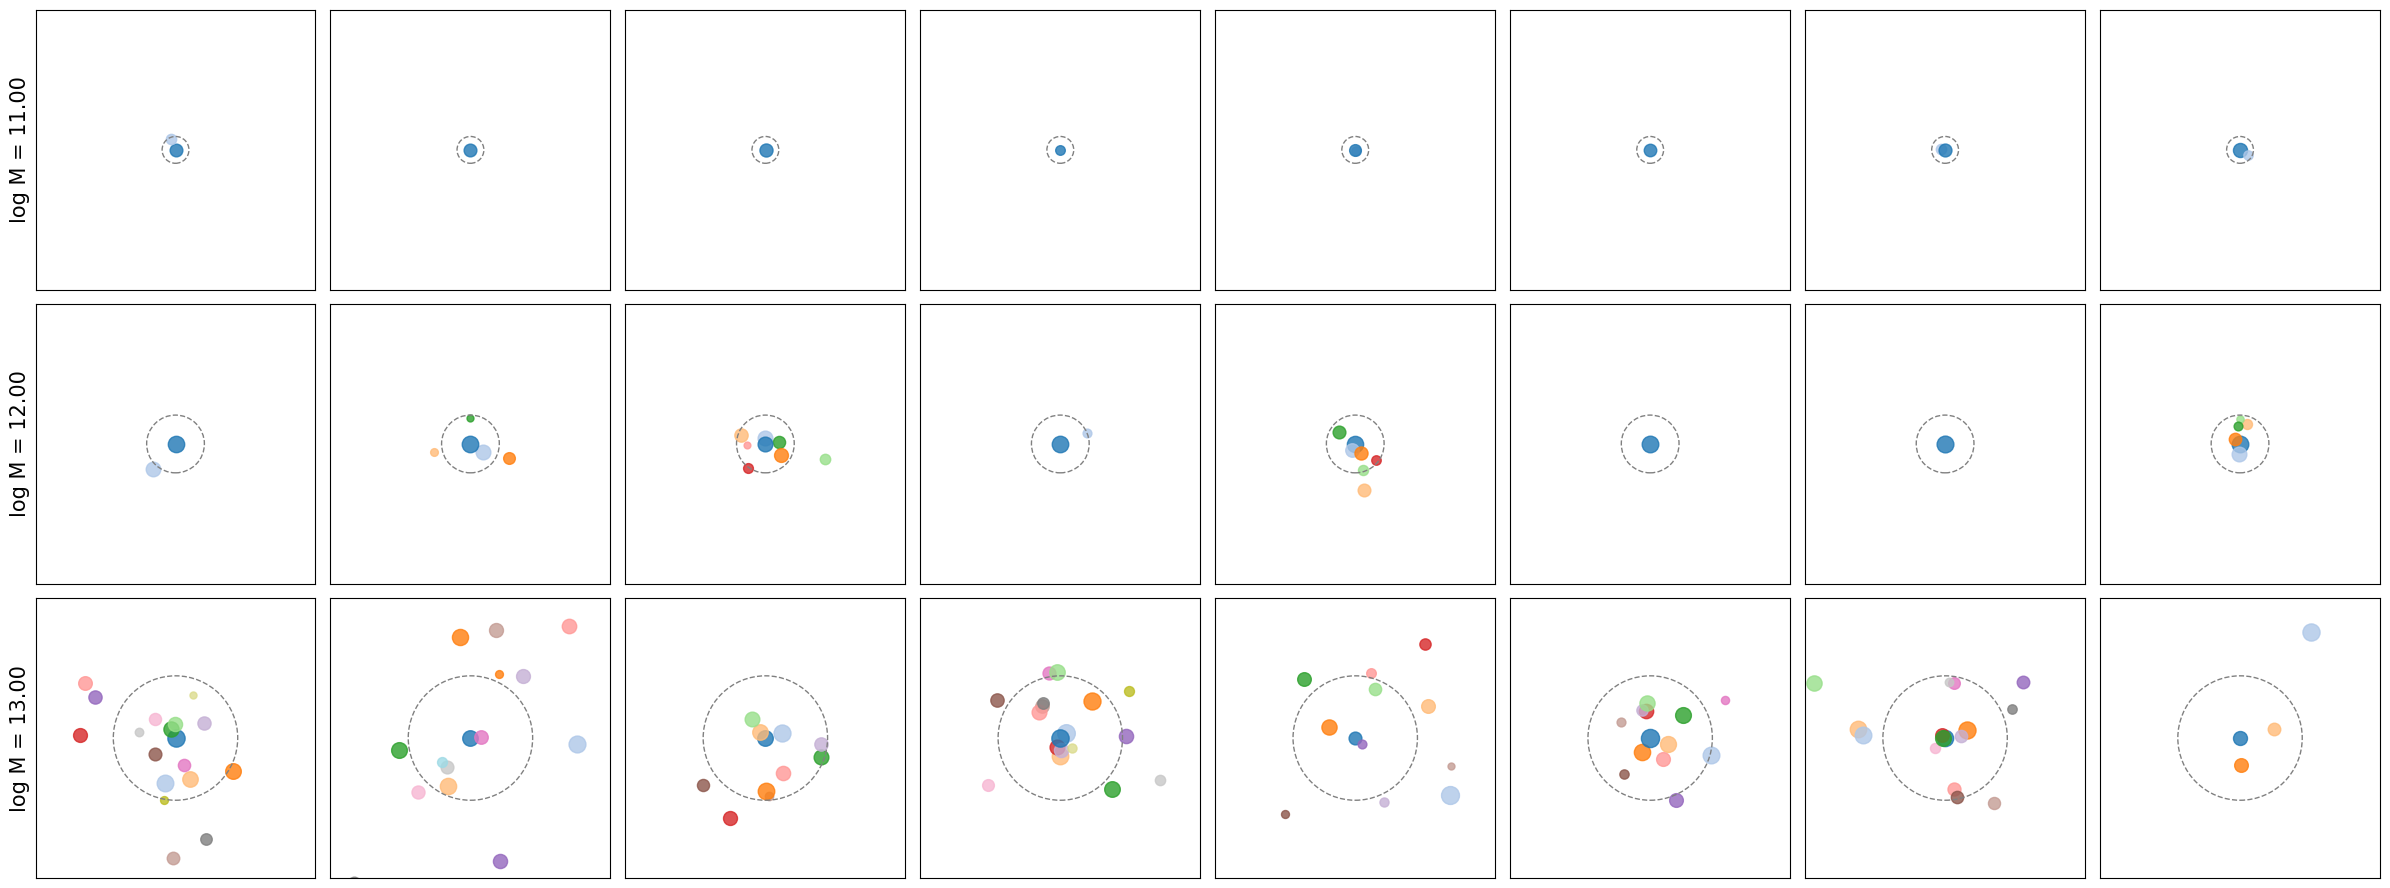

In [11]:
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def virial_radius(logM, z=0.0, delta_c=200, h=0.7, Omega_m=0.3, Omega_L=0.7):
    M = 10 ** logM
    G = 4.302e-9  # [Mpc * (km/s)^2 / Msun]
    Ez = np.sqrt(Omega_m * (1 + z)**3 + Omega_L)
    H_z = 100 * h * Ez
    rho_c_z = 3 * H_z**2 / (8 * np.pi * G)
    R_vir = (3 * M / (4 * np.pi * delta_c * rho_c_z))**(1/3)
    R_vir_mpc_h = R_vir * h
    return R_vir_mpc_h

def random_perpendicular_unit_vector(direction):
    N = len(direction)
    v_rand = np.random.randn(N, 3)
    dot = np.sum(v_rand * direction, axis=1, keepdims=True)
    v_tangent = v_rand - dot * direction
    v_tangent /= ( np.linalg.norm(v_tangent, axis=1, keepdims=True) + 1e-8 )

    return v_tangent

def show_distribution(gen, length, x_physical_unit, panel_id=[1,1,1], xmax_to_show=0.7, title_list=None, ylabel=None):
    if not isinstance(title_list, list):
        title_list = [None] * len(gen)

    if not isinstance(x_physical_unit, (list, np.ndarray)):
        x_physical_unit = [x_physical_unit] * len(gen)

    nrows, ncols, panel_id = panel_id

    for i, g in enumerate(gen):
    
        R = virial_radius(x_physical_unit[i])
        
        g = g[:length[i]]
        s = g[:, 0] * 200
        d = g[:, 1] * ( xmax[2] - xmin[2] ) + xmin[2]
        vr = g[:, 2] * ( xmax[3] - xmin[3] ) + xmin[3]
        vt = g[:, 3] * ( xmax[4] - xmin[4] ) + xmin[4]

        d = 10 ** d
        vr = np.sign( vr ) * (10 ** np.abs( vr ) - 1 )
        vt = 10 ** vt
        
        phi = np.random.uniform(0, 2*np.pi, len(s))
        theta = np.arccos(np.random.uniform(-1, 1, len(s)))
        dir_vector = np.stack([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)], axis=1)
        pos = d[:,None] * dir_vector

        vel_para_vector = - vr[:,None] * dir_vector # (N, 3)
        vel_perp_vector = vt[:,None] * random_perpendicular_unit_vector(dir_vector) # (N, 3)
        vel_vector = vel_para_vector + vel_perp_vector # (N, 3)
        vel_vector *= 0.0005

        ax = plt.subplot(nrows,ncols, panel_id+i) #, projection="3d")
        ax.set_aspect('equal')

        plt.title(title_list[i], fontsize=15)
        
        for j in range(len(s)):
            ax.scatter(pos[j,0], pos[j,1], s=s[j], color=colors[j], zorder=np.sign(pos[j,2]), alpha=0.8)
            #plt.arrow(pos[j,0], pos[j,1], vel_vector[j,0], vel_vector[j,1], color=colors[j], width=0.005, head_length=0.02)
            
        ax.set_xlim(-xmax_to_show, xmax_to_show)
        ax.set_ylim(-xmax_to_show, xmax_to_show)

        circle = plt.Circle((0, 0), R, color='gray', fill=False, ls="dashed")
        ax.add_artist(circle)

        plt.xticks([])
        plt.yticks([])

        if i == 0:
            ax.set_ylabel(ylabel, fontsize=15)


x_phys_list = [11.001, 12, 13]
ncols = 8
nrows = len(x_phys_list)
plt.figure(figsize=(ncols*3, nrows*3))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
panel_id = 1
for i, x_physical_unit in enumerate(x_phys_list):
    if x_physical_unit == 12:
        gen_test = generated_test
        length_gen_test = length_generated_test
    else:
        x_test = ( x_physical_unit - xmin[0] ) / ( xmax[0] - xmin[0] )
        x_test = [ x_test ] * 10
        x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
        gen_test, _ = model.generate(x_test, prob_threshold=1e-5, max_ids=max_ids)
        gen_test = gen_test.detach().cpu().numpy()
        length_gen_test = calc_length(gen_test)
    
    ylabel = "log M = {:.2f}".format(x_physical_unit)
    show_distribution(gen_test[:ncols], length_gen_test, x_physical_unit, panel_id=(nrows, ncols, panel_id), ylabel=ylabel)
    panel_id = panel_id + ncols

my_savefig("{}/distribution.pdf".format(output_dir))


# Load Halo Catalog and Generate Galaxies

In [4]:
### True data ###
data_path = "../dataset/TNG300-1/TNG300-1_33.h5"

ndata = None
#ndata = 10000
dataset_true = MyDataset(data_path, max_length=opt.max_length, norm_params=norm_params, ndata=ndata, use_dist=opt.use_dist, use_vel=opt.use_vel)
x_true = dataset_true.x
y_true = dataset_true.y_padded
mask = dataset_true.mask
print("Number of halos: ", len(x_true))
print("Number of galaxies: ", mask.sum().item())

### set threshold
#threshold = 1. / opt.num_features_out
threshold = ( -3.0 - xmin[1] ) / ( xmax[1] - xmin[1])
bin_of_threshold = int(threshold * opt.num_features_out)
print("threshold: ", threshold)
print("bin of threshold: ", bin_of_threshold)

prob_threshold = 1e-5 # p = 0 if p < prob_threshold

### model output ###
count = 0
generated = []
batch_size = opt.batch_size
batch_size = 1024
num_batch = (len(x_true) + batch_size - 1) // batch_size
count = 0
for i in tqdm(range(num_batch)):
    tmp = x_true[count:count+batch_size].to(device)
    gen, _ = model.generate(tmp, stop_criterion=threshold, prob_threshold=prob_threshold, max_ids=max_ids) 
    generated.append(gen)
    count += batch_size
generated = torch.cat(generated, dim=0)

x_true = x_true[:,0].detach().cpu().numpy() # (batch, num_condition) -> (batch,)
y_true = y_true.detach().cpu().numpy()
generated = generated.detach().cpu().numpy()

print("xmin: ", min(x_true) * (xmax[0] - xmin[0]) + xmin[0])
print("xmax: ", max(x_true) * (xmax[0] - xmin[0]) + xmin[0])

# Loading halo data from ../dataset/TNG300-1/TNG300-1_33.h5
Number of halos:  330287
Number of galaxies:  5027636
threshold:  0.03278688524590167
bin of threshold:  3


100%|██████████| 323/323 [00:18<00:00, 17.85it/s]


xmin:  11.000000927889062
xmax:  14.18677806854248


In [6]:
def calc_length(x, ref_param=0, skip_length=1): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    length = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        for j in range(skip_length, seq_length):
            if x[i,j,ref_param] < threshold:
                break
        length[i] = j
    return length

def calc_ngal_th(x, ref_param=0, threshold=threshold): 
    # skip the first element (central)
    # generated: (num_samples, seq_length, num_features_in)
    num_samples, seq_length, num_features_in = x.shape
    ngal = np.zeros(num_samples, dtype=int)
    for i in range(num_samples):
        if x[i,0,ref_param] > threshold:
            ngal[i] += 1
        for count, j in enumerate(range(1, seq_length)):
            if x[i,j,ref_param] < threshold:
                break
        ngal[i] += count

    return ngal

### calculate length ###
length_true = calc_length(y_true)
length_generated = calc_length(generated)

ngal_true_th01 = calc_ngal_th(y_true, threshold= ( np.log10( 0.1 ) - xmin[1] ) / ( xmax[1] - xmin[1]))
ngal_generated_th01 = calc_ngal_th(generated, threshold= ( np.log10( 0.1 ) - xmin[1] ) / ( xmax[1] - xmin[1]))

ngal_true_th1 = calc_ngal_th(y_true, threshold= ( np.log10( 1 ) - xmin[1] ) / ( xmax[1] - xmin[1]))
ngal_generated_th1 = calc_ngal_th(generated, threshold= ( np.log10( 1 ) - xmin[1] ) / ( xmax[1] - xmin[1]))

ngal_true_th10 = calc_ngal_th(y_true, threshold= ( np.log10( 10 ) - xmin[1] ) / ( xmax[1] - xmin[1]))
ngal_generated_th10 = calc_ngal_th(generated, threshold= ( np.log10( 10 ) - xmin[1] ) / ( xmax[1] - xmin[1]))

### binning ###
nbins = 20
xbins = np.linspace(0, 1, nbins+1)
xbins_physical_unit = xbins[:,None] * (xmax[None,:] - xmin[None,:]) + xmin[None,:] # (num_bins, num_params)

xbin_indices_true = np.digitize(x_true, xbins) - 1 # (num_samples,)
ybin_indices_true = np.digitize(y_true, xbins) - 1 # (num_samples, seq_length, num_params)
ybin_indices_generated = np.digitize(generated, xbins) - 1 # (num_samples, seq_length, num_params)

# Total SFR of halo
mask = np.arange(opt.max_length) < length_true[:,None]
output_masked = ( 10** (y_true[:,:,0] * ( xmax[1] - xmin[1] ) + xmin[1]) ) * mask
y_true_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_true_tot = np.sum(output_masked, axis=1)

mask = np.arange(opt.max_length) < length_generated[:,None]
output_masked = ( 10** (generated[:,:,0] * ( xmax[1] - xmin[1] ) + xmin[1]) ) * mask
y_generated_sat_tot = np.sum(output_masked[:,1:], axis=1)
y_generated_tot = np.sum(output_masked, axis=1)

y_true_sat_tot = np.log10(y_true_sat_tot) # (num_samples,)
y_true_tot = np.log10(y_true_tot) # (num_samples,)
y_generated_sat_tot = np.log10(y_generated_sat_tot) # (num_samples,)
y_generated_tot = np.log10(y_generated_tot) # (num_samples,)

1269972741.py:61: RuntimeWarning: divide by zero encountered in log10
1269972741.py:63: RuntimeWarning: divide by zero encountered in log10


# Plot Histogram

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/hist_length.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/hist_length_th.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/hist_length_sfr_bin.png
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/hist_total_sfr.pdf


/tmp/ipykernel_1032800/1781111551.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/hist_central_sfr_logm0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/hist_central_sfr_logm5.pdf


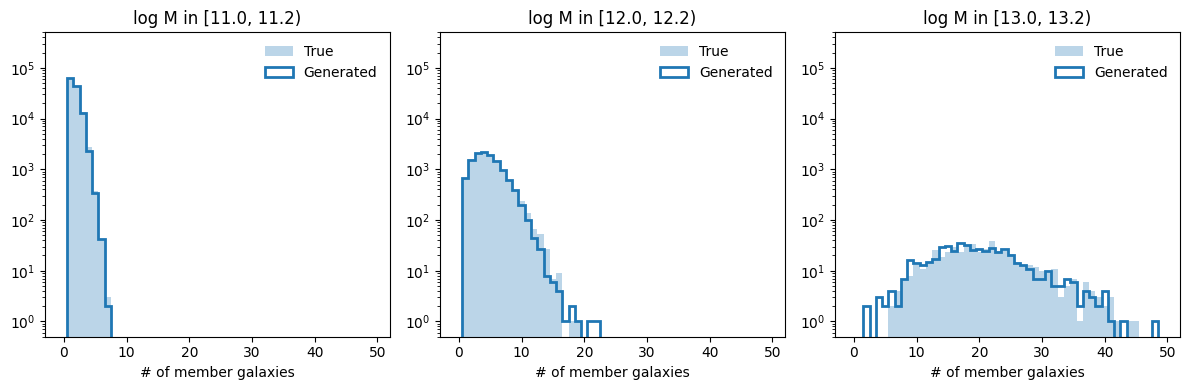

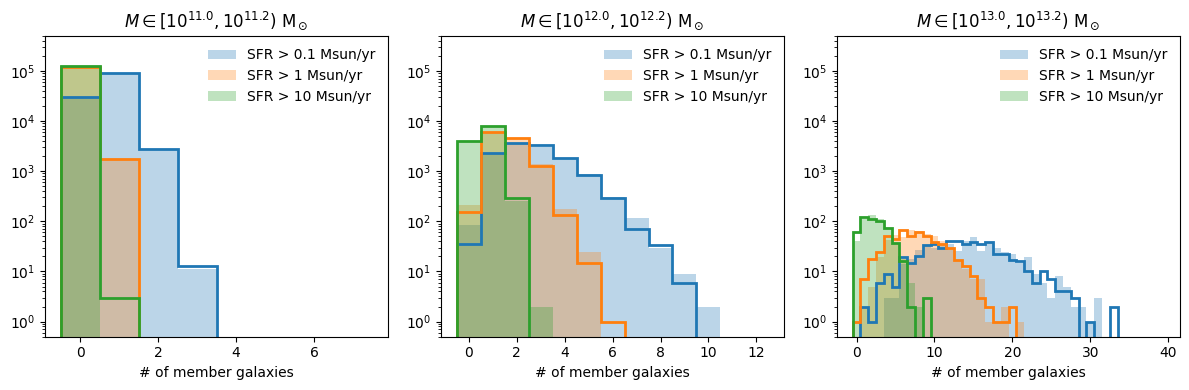

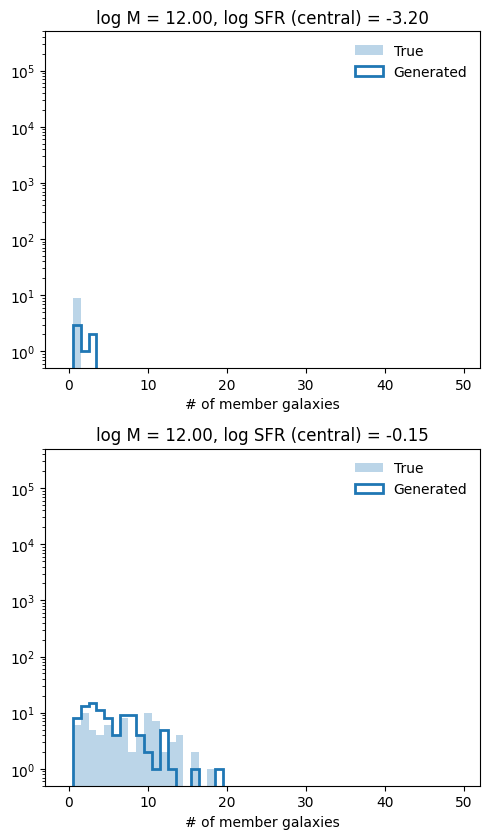

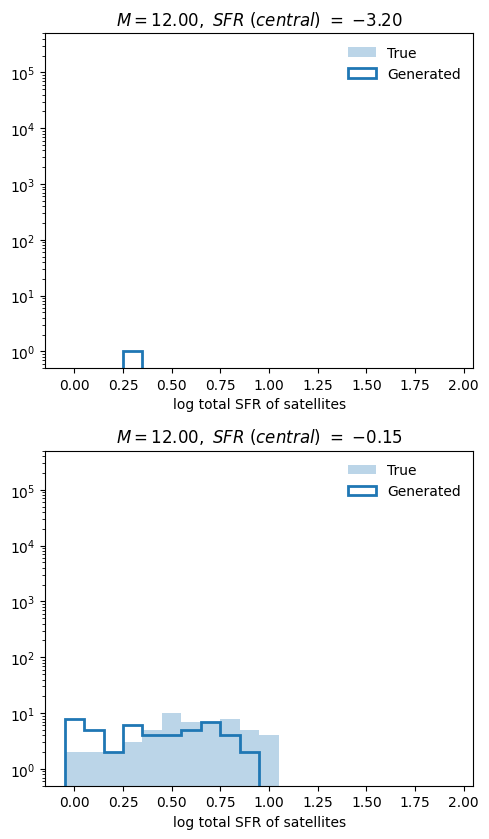

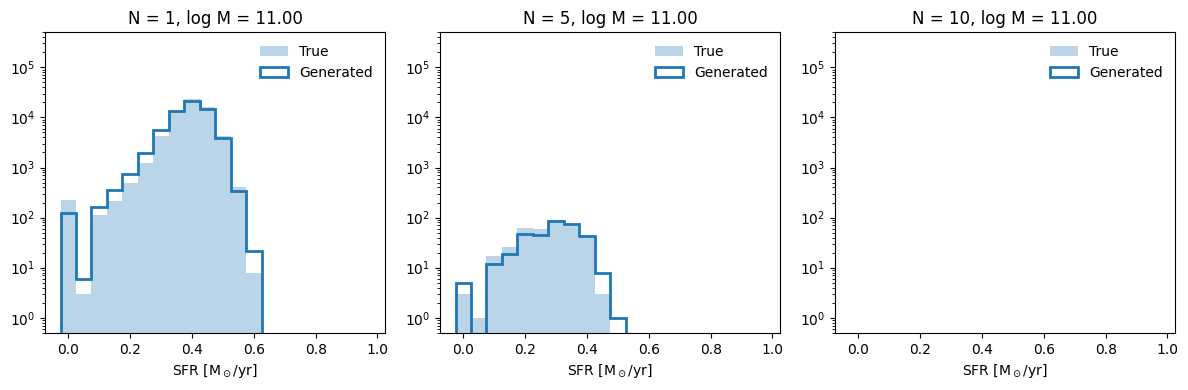

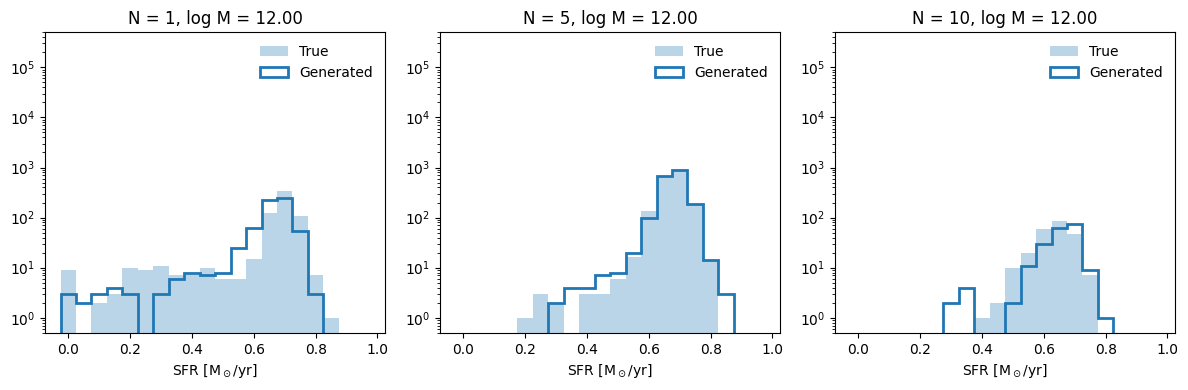

In [51]:
### Histograms 
density = False 
#density = True

def show_length_hist(length_list, indices=None, panel_id=(1,1,1), title=None, label_list=["True", "Generated"], xlabel="# of member galaxies", density=density, bin_range=(0,opt.max_length), bins=opt.max_length):

    if indices is None:
        indices = slice(None)
    if not isinstance(indices, (list)):
        indices = [ indices ] * len(length_list)
    if not isinstance(label_list, list):
        label_list = [label_list] * len(length_list)

    plt.subplot(*panel_id)
    plt.title(title)

    for i in range(len(length_list)):
        if i%2 == 0:
            n, bins, patches = plt.hist(length_list[i][indices[i]], range=bin_range, bins=bins, alpha=0.3, density=density, label=label_list[i], align="left")
        else:
            plt.hist(length_list[i][indices[i]], range=bin_range, bins=bins, alpha=1, density=density, label=label_list[i], align="left", histtype="step", color=patches[0].get_facecolor(), linewidth=2)

    plt.yscale("log")
    plt.xlabel(xlabel)
    if density:
        plt.ylim([1e-3, 1.5])
    else:
        plt.ylim([5e-1, 5e5])
    plt.legend(frameon=False)

### Length in bins of log M
list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
for count, i in enumerate(list_to_show):
    indices = np.where(xbin_indices_true == i)[0]
    title = "log M in [{:.1f}, {:.1f})".format(xbins_physical_unit[i,0], xbins_physical_unit[i+1,0])
    show_length_hist([length_true, length_generated], indices=indices, panel_id=(1,len(list_to_show),count+1), title=title, density=density)

fout = f"{output_dir}/hist_length.pdf"
my_savefig(fout)

### Length with SFR > th in bins of log M
list_to_show = [0, 5, 10]
plt.figure(figsize=(len(list_to_show)*4, 4))
l_list = [ngal_true_th01, ngal_generated_th01, ngal_true_th1, ngal_generated_th1, ngal_true_th10, ngal_generated_th10]
label_list = ["SFR > 0.1 Msun/yr", "", 
              "SFR > 1 Msun/yr", "", 
              "SFR > 10 Msun/yr", ""]
bin_ranges = [(0, 8), (0, 13), (0, 40)]
for count, i in enumerate(list_to_show):
    indices = np.where(xbin_indices_true == i)[0]
    title = r"$M \in [10^{%.1f}, 10^{%.1f})\ \rm M_\odot$" % (xbins_physical_unit[i,0], xbins_physical_unit[i+1,0])

    show_length_hist(l_list, indices=indices, panel_id=(1,len(list_to_show),count+1), title=title, label_list=label_list, density=density, bin_range=bin_ranges[count], bins=bin_ranges[count][1])
fout = f"{output_dir}/hist_length_th.pdf"
my_savefig(fout)


### length in bins in (log M, log SFR)
list_to_show = [5]
y_list_to_show = [0, 10]
plt.figure(figsize=(len(list_to_show)*5, len(y_list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)
    for j in y_list_to_show:
        indices = [
            np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0],
            np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        ]
        title = "log M = {:.2f}, log SFR (central) = {:.2f}".format(xbins_physical_unit[i,0], xbins_physical_unit[j,1])
        show_length_hist([length_true, length_generated], indices=indices, panel_id=(len(y_list_to_show),len(list_to_show),count+1), title=title, density=density)        
        count += 1

fout = f"{output_dir}/hist_length_sfr_bin.png"
my_savefig(fout)

### Total satellite SFR in bins in (log M, length)
list_to_show = [5]
y_list_to_show = [0, 10]
plt.figure(figsize=(len(list_to_show)*5, len(y_list_to_show)*4+0.5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
count = 0
for i in list_to_show:
    base_mask = (xbin_indices_true == i)
    for j in y_list_to_show:
        indices = [
            np.where((ybin_indices_true[:,0,0] == j) & base_mask )[0],
            np.where((ybin_indices_generated[:,0,0] == j) & base_mask)[0]
        ]
        title = r"$M = {%.2f}, \ SFR\  (central)\  =\ {%.2f}$"%(xbins_physical_unit[i,0], xbins_physical_unit[j,1])
        show_length_hist([y_true_sat_tot, y_generated_sat_tot], indices=indices, panel_id=(len(y_list_to_show),len(list_to_show),count+1), title=title, density=density, bin_range=(0,2), bins=20, xlabel="log total SFR of satellites")        
        count += 1

fout = f"{output_dir}/hist_total_sfr.pdf"
my_savefig(fout)

### Central SFR in bins in (log M, length)
list_to_show = [0, 5]
length_list_to_show = [1, 5, 10]
for i_logm in list_to_show:
    base_mask = (xbin_indices_true == i_logm)
    for iparam in range(1): # only for the first parameter    
        plt.figure(figsize=(len(length_list_to_show)*4, 4))
        for count, i in enumerate(length_list_to_show):
            
            plt.subplot(1, len(length_list_to_show), count+1)
            title = "N = {:d}, log M = {:.2f}".format(i, xbins_physical_unit[i_logm, 0])
            indices = [
                np.where((length_true == i) & base_mask )[0],
                np.where((length_generated == i) & base_mask)[0]
            ]
            show_length_hist([y_true[:,0,iparam], generated[:,0,iparam]], indices=indices, panel_id=(1,len(length_list_to_show),count+1), title=title, density=density, bin_range=(0,1), bins=20, xlabel=param_names[iparam])   

        fout = f"{output_dir}/hist_central_sfr_logm{i_logm}.pdf" 
        my_savefig(fout)

# Mass vs X 

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/logm_x.pdf


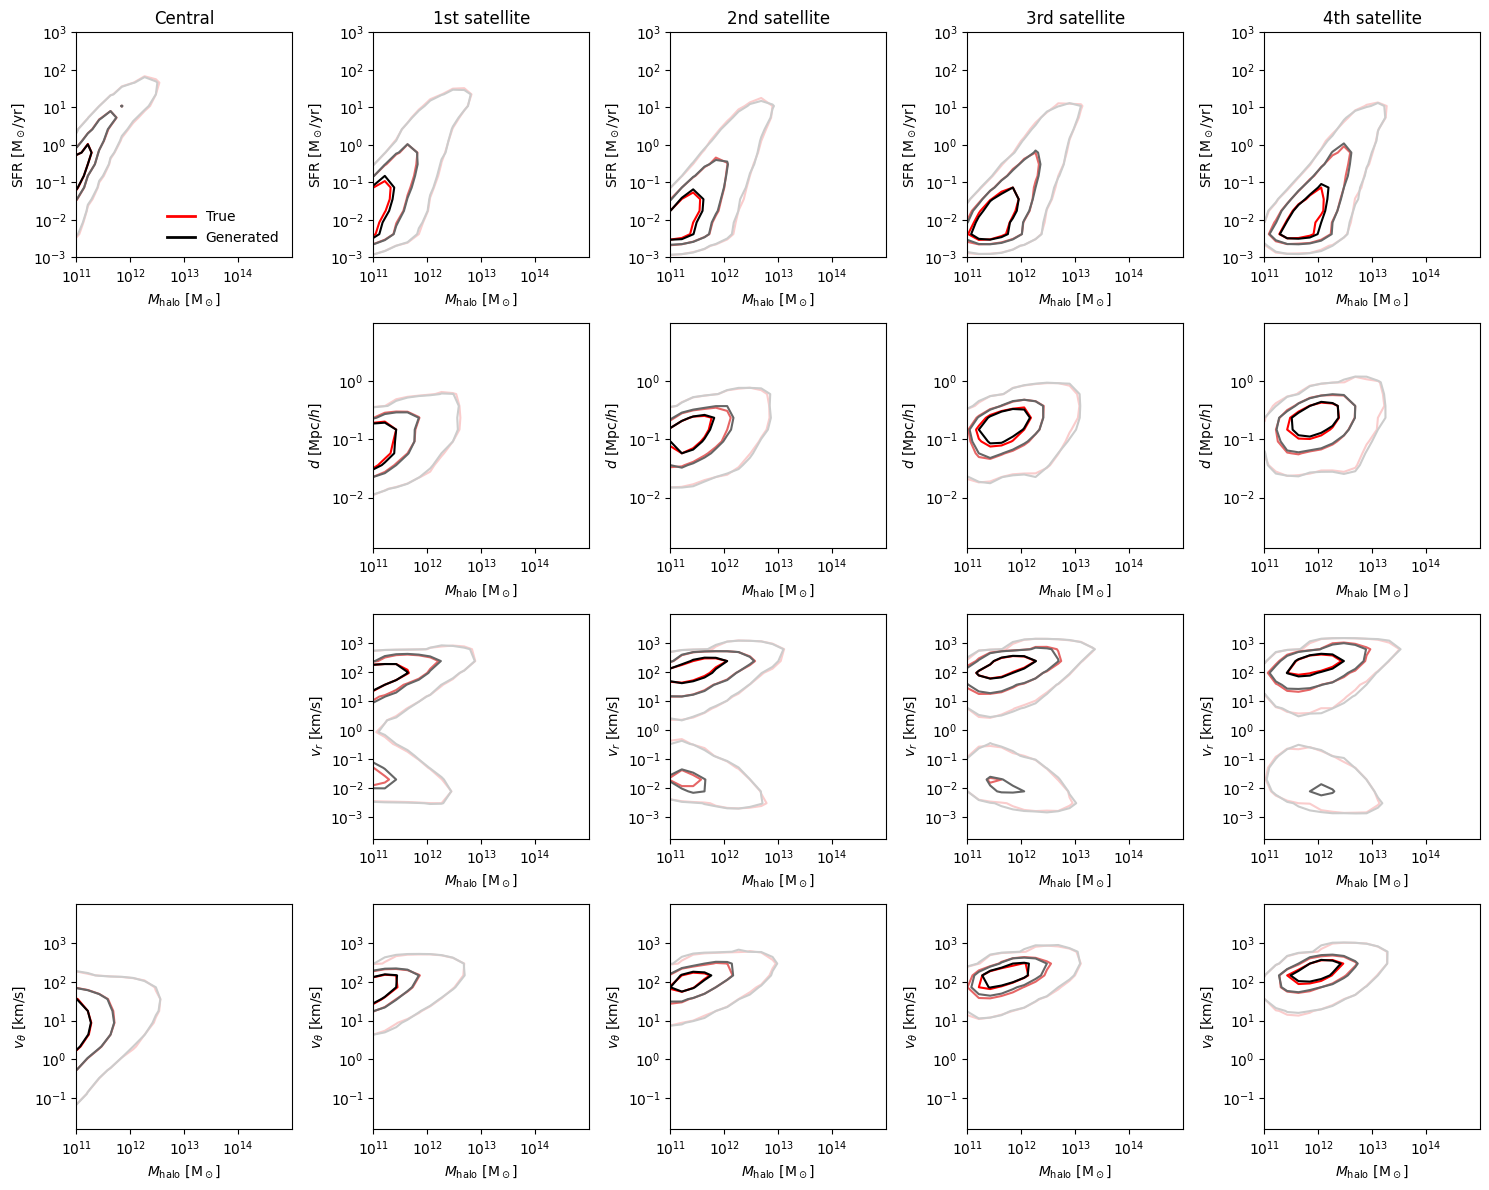

In [28]:

from matplotlib.lines import Line2D

### comparison of M-SFR relations 
show_scatter = True
show_scatter = False

show_diff = False

colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

max_length_to_show = 5

def compute_contoure_levels(grid_data, sigma_levels=[0.9545, 0.6827, 0.383]): #[0.9973, 0.9545, 0.6827, 0.383]
    grid_data = grid_data / np.sum(grid_data)
    grid_data_sorted = np.sort(grid_data.flatten())[::-1]
    cumsum = np.cumsum(grid_data_sorted)

    levels = [ grid_data_sorted[np.where(cumsum > sigma)[0][0]] for sigma in sigma_levels ]

    return grid_data, levels

plt.figure(figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
    
target_x = [1e11, 1e12, 1e13, 1e14]
tick_x = [ ( np.log10(t) - xmin[0] ) / ( xmax[0] - xmin[0]) for t in target_x ]

for iparam in range(opt.num_features_in):
    for i in range(max_length_to_show):
        if iparam == 1 and i == 0:
            continue
        if iparam == 2 and i == 0:
            continue

        mask = length_true > i 
        xnow_true = x_true[mask]
        ynow_true = y_true[mask]
        mask = length_generated > i 
        xnow = x_true[mask]
        ynow = generated[mask]

        plt.subplot(4,5,i+1 + iparam * max_length_to_show) 
        if iparam == 0:
            if i == 0:
                plt.title("Central")
            elif i == 1:
                plt.title("1st satellite")
            elif i == 2:
                plt.title("2nd satellite")
            elif i == 3:
                plt.title("3rd satellite")
            else:
                plt.title("{:d}th satellite".format(i))  

        handle_list = []
        if show_scatter:
            plt.scatter(xnow_true, ynow_true[:,i,iparam], s=1, color="blue", alpha=0.5)
            plt.scatter(xnow, ynow[:,i,iparam], s=1, color="red", alpha=0.5)
        else:
            hist_range = [[0,1],[threshold,1]]
            extent = [0,1,threshold,1]

            hist = np.histogram2d(xnow_true, ynow_true[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contoure_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=colors_red, levels=levels)
            handle_list.append(plt.Line2D([0], [0], color=colors_red[-1], lw=2, label="True"))
            
            hist = np.histogram2d(xnow, ynow[:,i,iparam], bins=20, range=hist_range)
            grid_data, levels = compute_contoure_levels(hist[0])
            plt.contour(grid_data.T, extent=extent, colors=colors_black, levels=levels)
            handle_list.append(plt.Line2D([0], [0], color=colors_black[-1], lw=2, label="Generated"))

        if iparam == 0:
            target_y = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
        elif iparam == 1:
            target_y = [1e-2, 1e-1, 1]
        elif iparam == 2:
            target_y = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
        elif iparam == 3:
            target_y = [1e-1, 1, 10, 100, 1000]

        if iparam == 2:
            tick_y = [ ( np.sign(t) * np.log10(np.abs(t)) - xmin[3] ) / ( xmax[3] - xmin[3]) for t in target_y ]
        else:
            tick_y = [ ( np.log10(t) - xmin[iparam+1] ) / ( xmax[iparam+1] - xmin[iparam+1]) for t in target_y ]

        plt.yticks(tick_y, [r"$10^{%.0f}$"%(np.log10(t)) for t in target_y])
        plt.ylabel(param_names[iparam])

        plt.xticks(tick_x, [r"$10^{%.0f}$"%(np.log10(t)) for t in target_x])
        plt.xlabel(r"$M_{\rm halo}\ \rm [M_\odot]$")

        if i == 0 and iparam == 0:
            plt.legend(handles=handle_list, loc="lower right", frameon=False)

    if show_scatter:
        break

fout = f"{output_dir}/logm_x.pdf"
my_savefig(fout)

    

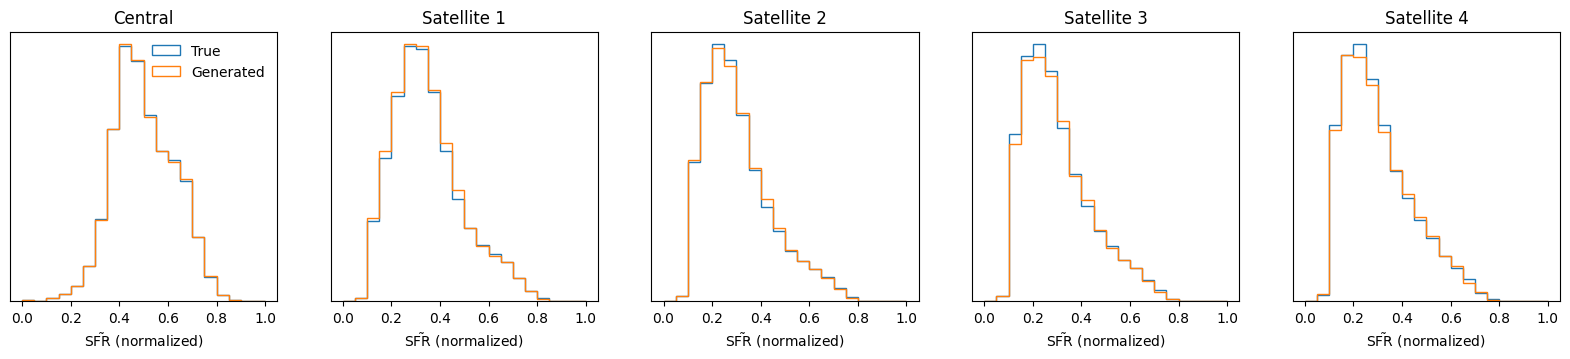

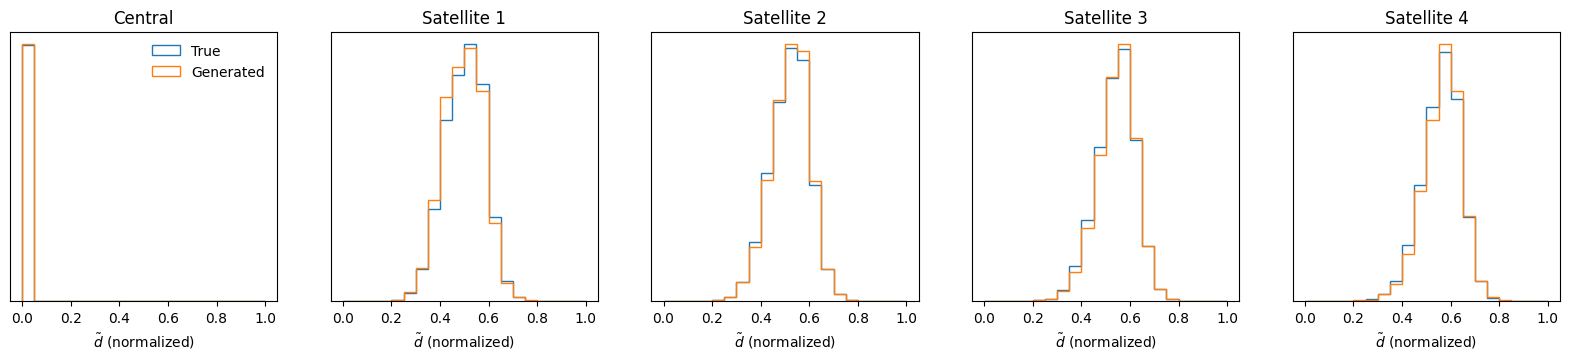

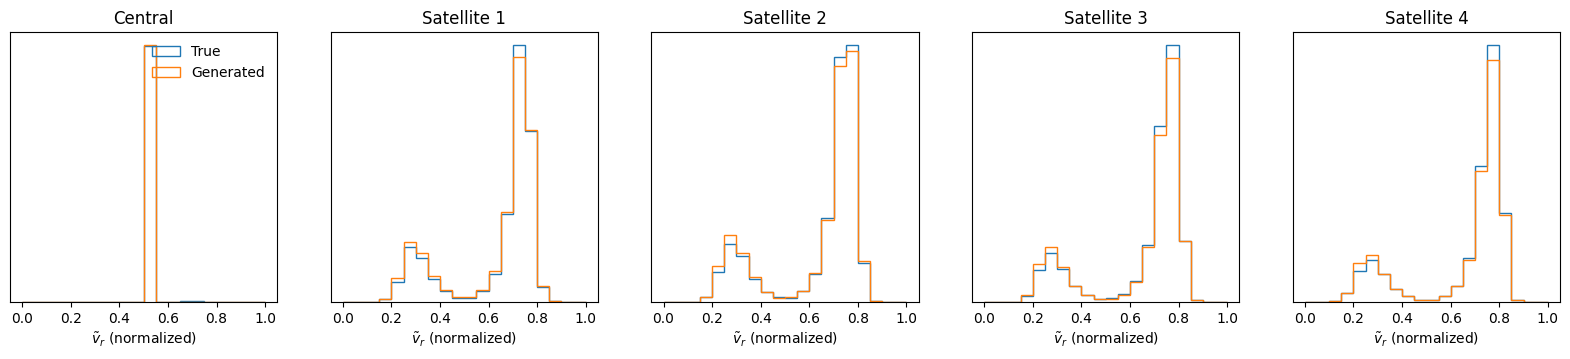

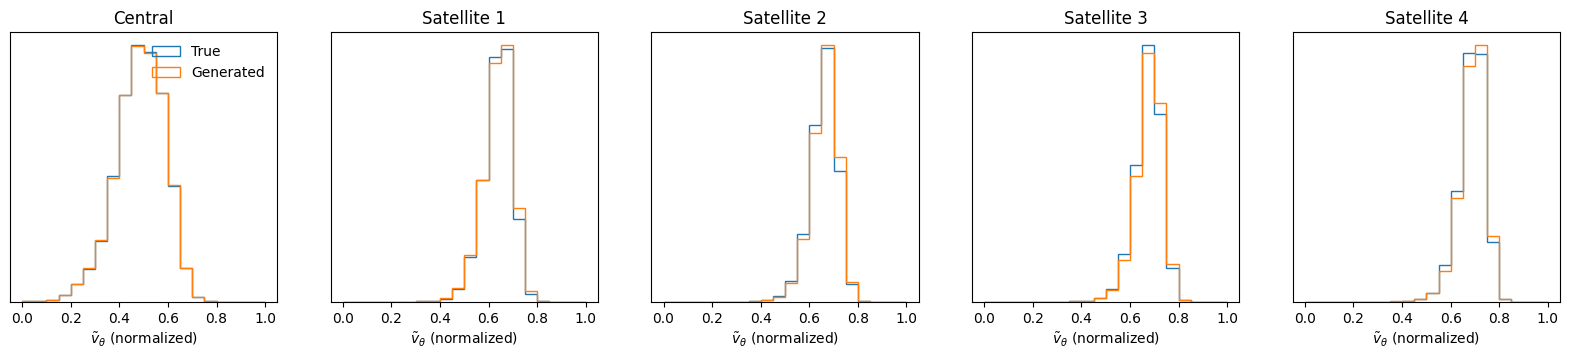

In [9]:
max_length_to_show = 5

for iparam in range(opt.num_features_in):
    ynow_true = y_true
    ynow = generated

    plt.figure(figsize=(20,3.5))
    for isat in range(max_length_to_show):
        plt.subplot(1,max_length_to_show,isat+1)
        if isat == 0:
            plt.title("Central")
        else:
            plt.title(f"Satellite {isat}")
            ynow_true = ynow_true[ynow_true[:,isat,0]>threshold]
            ynow = ynow[ynow[:,isat,0]>threshold]

        plt.hist(ynow_true[:,isat,iparam], histtype="step", bins=20, range=(0,1), label="True")
        plt.hist(ynow[:,isat,iparam], histtype="step", bins=20, range=(0,1), label="Generated")
        if isat == 0:
            plt.legend(loc="upper right", frameon=False)

        plt.xlabel(f"{param_names[iparam]} (normalized)")
        plt.yticks([])

# Correlation between galaxies

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/contour_0_1_logm11.0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/contour_0_1_logm12.0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/contour_0_1_logm12.4.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/contour_0_1_logm13.0.pdf


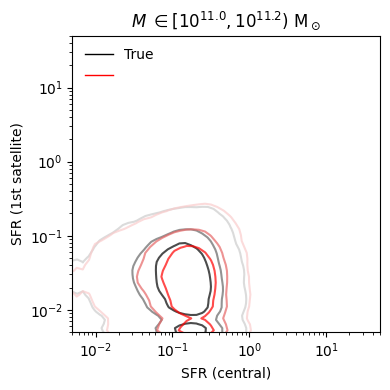

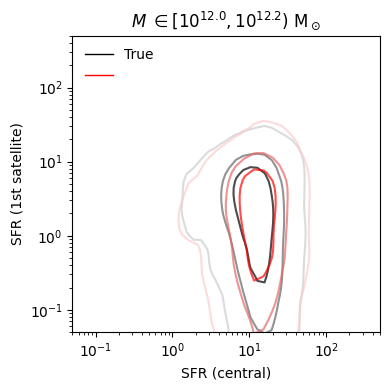

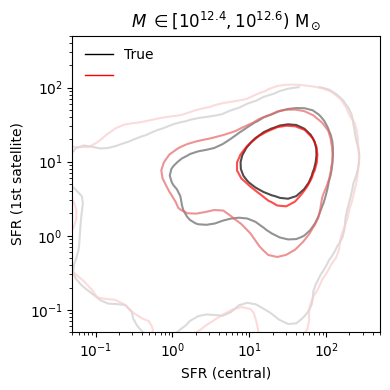

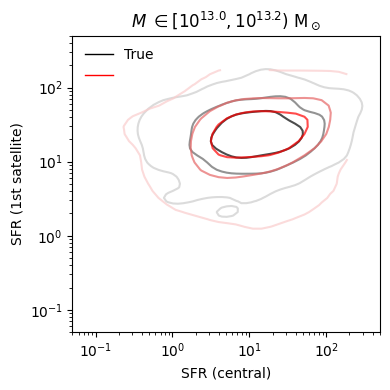

In [11]:
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

def plot_contour(y1, y2, colors, label=None, nbins=50):
    logy1 = np.log10(y1)
    logy2 = np.log10(y2)
    values = np.vstack([logy1, logy2])
    kde = gaussian_kde(values)

    xgrid = np.linspace(logy1.min(), logy1.max(), nbins)
    ygrid = np.linspace(logy2.min(), logy2.max(), nbins)
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(positions).reshape(X.shape)

    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]  
    cumsum = np.cumsum(Z_sorted)
    cumsum /= cumsum[-1]  

    levels = []
    for target in [0.9545, 0.6827, 0.383]: #[0.9973, 0.9545, 0.6827, 0.383]:
        idx = np.searchsorted(cumsum, target)
        levels.append(Z_sorted[idx])

    contour = plt.contour(10 ** X, 10 ** Y, Z, levels=levels, colors=colors, alpha=0.7)

    return Line2D([0], [0], color=colors[-1], label=label, lw=1)
    
colors_black = [(0.8, 0.8, 0.8),(0.4, 0.4, 0.4),"black"]
colors_red = [(0.98, 0.8, 0.8),(0.9, 0.4, 0.4),"red"]

_nbins = 20
_xbins = np.linspace(0, 1, _nbins+1)
_xbins_physical_unit = _xbins[:,None] * (xmax[None,:] - xmin[None,:]) + xmin[None,:] # (num_bins, num_params)

_xbin_indices_true = np.digitize(x_true, _xbins) - 1 # (num_samples,)

for i in [0, 5, 7, 10]: #[5,7,9]:
    i0 = 0
    i1 = 1
    if i < 5:
        xlim = (5e-3, 5e1)
    else:
        xlim = (5e-2, 5e2)

    handle_list = []
    plt.figure(figsize=(4,4))

    #plt.title("log M in [{:.1f}, {:.1f})".format(xbins_physical_unit[i,0], xbins_physical_unit[i+1,0]))
    plt.title(r"$M\ \in [10^{%.1f}, 10^{%.1f})\ \rm  M_\odot$" % (_xbins_physical_unit[i,0], _xbins_physical_unit[i+1,0]))
    
    mask = (_xbin_indices_true == i) & (length_true > max(i0, i1))
    y1now = y_true[mask][:,i0,0] * (xmax[1] - xmin[1]) + xmin[1]
    y2now = y_true[mask][:,i1,0] * (xmax[1] - xmin[1]) + xmin[1]
    y1now = 10 ** y1now
    y2now = 10 ** y2now

    line_label = plot_contour(y1now, y2now, colors=colors_black, label="True")
    handle_list.append(line_label)

    mask = (_xbin_indices_true == i) & (length_generated > max(i0, i1))
    y1now = generated[mask][:,i0,0] * (xmax[1] - xmin[1]) + xmin[1]
    y2now = generated[mask][:,i1,0] * (xmax[1] - xmin[1]) + xmin[1]
    y1now = 10 ** y1now
    y2now = 10 ** y2now

    line_label = plot_contour(y1now, y2now, colors=colors_red)
    handle_list.append(line_label)

    if iparam ==

    plt.legend(handles=handle_list, loc="upper left", frameon=False)

    plt.xlim(xlim)
    plt.ylim(xlim)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("SFR (1st satellite)")
    
    plt.xlabel("SFR (central)")
    
    my_savefig("{}/contour_0_1_logm{:.1f}.pdf".format(output_dir, _xbins_physical_unit[i,0]))

In [7]:
mask = np.arange(opt.max_length) < length_true[:,None]
Pshot_true = ( 10** (y_true[:,:,0] * ( xmax[1] - xmin[1] ) + xmin[1]) ) ** 2
Pshot_true = ( Pshot_true * mask ).sum()

mask = np.arange(opt.max_length) < length_generated[:,None]
Pshot_generated = ( 10** (generated[:,:,0] * ( xmax[1] - xmin[1] ) + xmin[1]) ) ** 2
Pshot_generated = ( Pshot_generated * mask ).sum()

print("Pshot (True): ", Pshot_true)
print("Pshot (Generated): ", Pshot_generated)
print("Pshot ratio: ", Pshot_generated / Pshot_true)

Pshot (True):  33237453.20392045
Pshot (Generated):  32696607.27659302
Pshot ratio:  0.9837278168092723


# Radial Profile

_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide


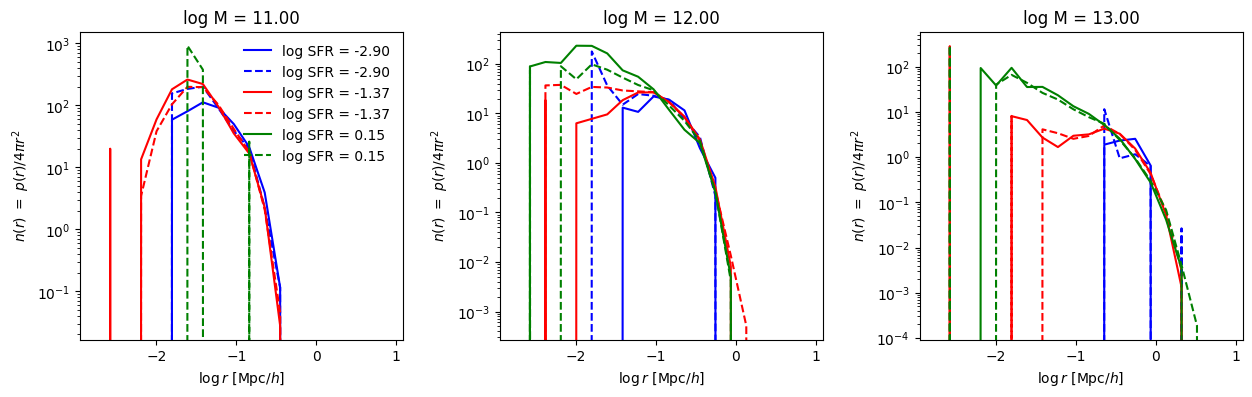

In [28]:
## radial profile
list_to_show = [0, 5, 10]
y_list_to_show = [1, 6, 11]
color_list = ["blue", "red", "green"]

plt.figure(figsize=(len(list_to_show)*5, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.2)
for count, i_logm in enumerate(list_to_show):
    plt.subplot(1, len(list_to_show), count+1)
    plt.title(f"log M = {xbins_physical_unit[i_logm, 0]:.2f}")
    base_mask = (xbin_indices_true == i_logm)
    for jj, j in enumerate(y_list_to_show):

        ls_list = ["-", "--"]
        for iy, ynow in enumerate([y_true, generated]):
            ynow = ynow[base_mask]
            bin_indices_now = np.digitize(ynow[:,:,0], xbins) - 1
            ynow = ynow[bin_indices_now == j]

            hist, bins = np.histogram(ynow[:,1], range=(threshold,1), bins=20, density=True)
            logr = bins * (xmax[2] - xmin[2]) + xmin[2]
            
            logr = 0.5 * (logr[1:] + logr[:-1])
            hist /= 4 * np.pi * ( 10 ** logr ) ** 2

            plt.plot(logr, hist, label=f"log SFR = {xbins_physical_unit[j, 1]:.2f}", color=color_list[jj], ls=ls_list[iy])

    plt.yscale("log")
    
    if count == 0:
        plt.legend(frameon=False, loc="upper right")
    plt.ylabel(r"$n (r) \ = \ p(r) / 4\pi r^2$")
    plt.xlabel(r"$\log r \ [{\rm Mpc}/h] $")



# Visualize Attention Weights

Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_0.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_1.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_2.pdf
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/attn_layer_3.pdf


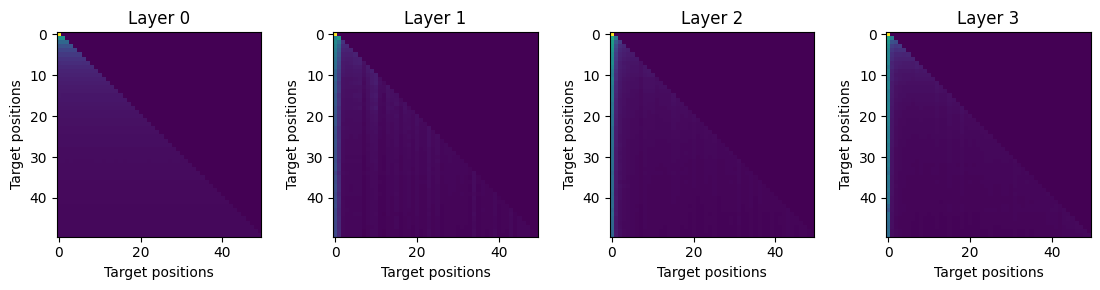

In [12]:
### Transformer attention visualization
opt_now = copy.deepcopy(opt)
opt_now.model_name = opt.model_name + "_with_attn"
model_now = transformer_model(opt_now)
model_now.to(device)

model_now.load_state_dict(torch.load(f"{model_dir}/model.pth"))
model_now.eval()

attn_weights = {}

def get_hook(name):
    def hook(module, input, output):
        attn_weights[name] = output[1].detach().cpu() 
    return hook

for i, layer in enumerate(model_now.decoder.layers):
    layer.self_attn.register_forward_hook(get_hook(f'layer_{i}_self_attn'))

con = torch.from_numpy(x_true[0:1]).unsqueeze(-1).to(device)
seq = torch.from_numpy(y_true[0:1,:-1,:]).to(device)

output = model_now(con, seq)

plt.figure(figsize=(3* opt_now.num_layers, 3))
for i in range(opt_now.num_layers):
    attn_matrix = attn_weights[f'layer_{i}_self_attn'][0].numpy()  # (tgt_len, tgt_len)

    plt.subplot(1, opt_now.num_layers, i + 1)
    plt.imshow(attn_matrix, cmap='viridis')
    #plt.colorbar()
    plt.title(f"Layer {i}")
    plt.xlabel("Target positions")
    plt.ylabel("Target positions")

    plt.tight_layout()
    my_savefig(f"{output_dir}/attn_layer_{i}.pdf")


# Distribution of True Galaxies

11.0 11.04
12.0 12.04
13.0 13.04
Saved figure to ../scripts/runs/output_transformer/transformer1_33_use_vel_ep40_bs512_w0.02/figures/distribution_true.pdf


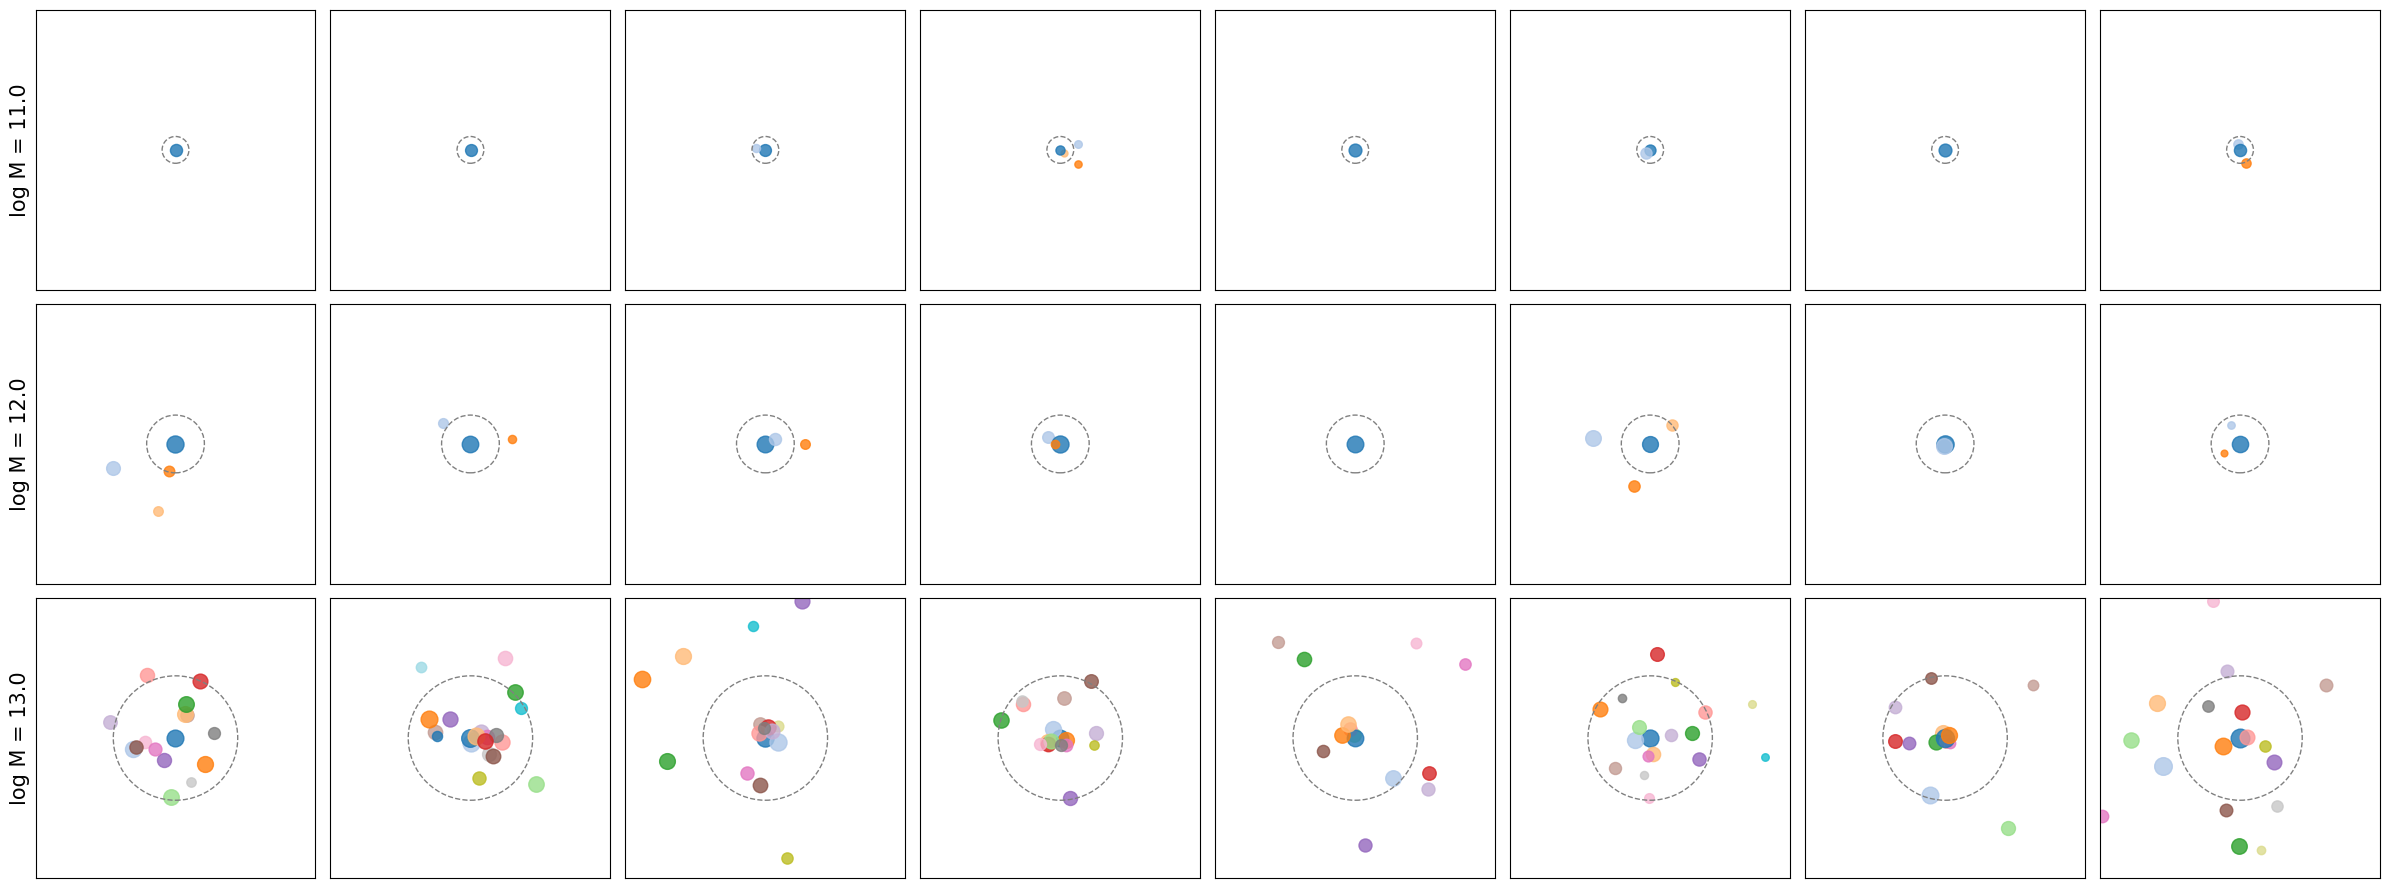

In [13]:
seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Distribution of true galaxies
_nbins = 100
_xbins = np.linspace(0, 1, _nbins+1)
_xbins_physical_unit = _xbins[:,None] * (xmax[None,:] - xmin[None,:]) + xmin[None,:] # (num_bins, num_params)

_xbin_indices_true = np.digitize(x_true, _xbins) - 1 # (num_samples,)

list_to_show = [0, 25, 50] #, 74, 75]
ncols = 8
nrows = len(list_to_show)
plt.figure(figsize=(ncols*3, nrows*3))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
panel_id = 1
for count, i in enumerate(list_to_show):
    x_physical_unit = _xbins_physical_unit[i,0]
    print(_xbins_physical_unit[i,0], _xbins_physical_unit[i+1,0])
    mask = np.where(_xbin_indices_true == i)[0]
    
    ynow = y_true[mask]
    len_now = length_true[mask]

    indices = np.random.permutation(len(ynow))
    ynow= ynow[indices]
    len_now = len_now[indices]

    show_distribution(ynow[:ncols], len_now, x_physical_unit, panel_id=(nrows, ncols, panel_id), ylabel="log M = {:.1f}".format(x_physical_unit))
    panel_id = panel_id + ncols

my_savefig("{}/distribution_true.pdf".format(output_dir))
